# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Webscraping Project 4 Lab

Week 4 | Day 4

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com (or other sites at your team's discretion). In the second part, the focus is on using listings with salary information to build a model and predict high or low salaries and what features are predictive of that result.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
from selenium import webdriver

In [3]:
path_phantom = '//Applications/phantomjs'

In [13]:
## YOUR CODE HERE
driver = webdriver.PhantomJS(executable_path=path_phantom)

In [5]:
driver.get(URL)

In [6]:
soup = BeautifulSoup(driver.page_source, 'lxml')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above
- Include any other features you may want to use later (e.g. summary, #of reviews...)

In [7]:
## YOUR CODE HERE
def extract_location_from_result(result):
    try:
        location = result.find('span', class_='location').text.strip()
    except:
        location = ''
    return location

def extract_title_from_result(result):
    try:
        job_title = result.find('a', class_='jobtitle').text.strip('\n')
    except:
        try:
            job_title = result.find('h2', class_='jobtitle').text.strip('\n')
        except:
            job_title = ''
    return job_title

def extract_summary_from_result(result):
    try:
        summary = result.find('span', class_='summary').text.strip()
    except:
        summary = ''
    return summary

def extract_company_from_result(result):
    try:
        company = result.find('span', class_='company').text.strip()
    except:
        company = ''
    return company

def extract_reviews_from_result(result):
    try:
        sub = result.find('span', class_='slNoUnderline').text.strip()
        if 'review' in sub:
            reviews = sub.split()[0]
    except:
        reviews = ''
    return reviews

def extract_salary_from_result(result):
    try:
        salary = result.find('td', class_='snip').find('nobr').text.strip()
#         salary_text = salary_text.split()
#         salary = float(salary_text[0].strip('$').replace(',',''))
    except:
        salary = ''
    return salary

def get_all_details(result):
    return [extract_title_from_result(result),\
            extract_company_from_result(result),\
            extract_location_from_result(result),\
            extract_reviews_from_result(result),\
            extract_summary_from_result(result),\
            extract_salary_from_result(result)]

In [8]:
import pandas as pd

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Indeed.com only has salary information for an estimated 20% of job postings. You may want to add other cities to the list below to gather more data. 
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [14]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 100

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Atlanta']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        full_url = url_template.format(city, start)
        driver.get(full_url)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        # Append to the full set of results
        for item in soup.findAll('div', class_='result'):
            results.append(get_all_details(item))
#         pass

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [10]:
## YOUR CODE HERE

In [15]:
df = pd.DataFrame(results, columns=['title', 'company', 'location', 'reviews', 'summary', 'salary'])

In [16]:
df.shape

(748, 6)

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [17]:
## YOUR CODE HERE

In [18]:
df['hourly'] = df['salary'].map(lambda x: 1 if 'hour' in x else 0)

In [19]:
df['monthly'] = df['salary'].map(lambda x: 1 if 'month' in x else 0)

In [20]:
df['yearly'] = df['salary'].map(lambda x: 1 if 'year' in x else 0)

In [21]:
df[df['hourly'] == 1]

,title,company,location,reviews,summary,salary,hourly,monthly,yearly
229,Forensic Scientist-DNA (8 Openings),City of Austin,"Austin, TX",85,Skill in data analysis and problem solving. Gr...,$23.44 - $29.80 an hour,1,0,0


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [22]:
import numpy as np

In [74]:
## YOUR CODE HERE
def get_salary_amount(salary_string):
    try:
        salary_string.replace('-', ' ')
        sal_list = salary_string.split()
        figures = []
        for i in sal_list:
            try:
#                 print i.strip('$')
                figures.append(float(i.strip('$').replace(',','')))
            except:
                pass
#         print figures
        return (np.mean(figures))
    except:
        return np.nan

In [68]:
df[df['salary'] != '']

,title,company,location,reviews,summary,salary,hourly,monthly,yearly,est_sal
159,Statistical Analyst,Health & Human Services Comm,"Austin, TX",,Creation of data appropriate statistical sampl...,"$4,599 - $6,066 a month",0,1,0,NaN
161,Microbiology Supervisor / MLS Program Director,Dept of State Health Services,"Austin, TX",18,Evaluates and interprets highly complex data. ...,"$4,500 - $4,900 a month",0,1,0,NaN
162,Research Engineering/ Scientist Associate II -...,University of Texas at Austin,"Austin, TX",403,Contribute to funded research projects enablin...,"$4,916 a month",0,1,0,NaN
169,Engineering Scientist Associate - R and D Soft...,University of Texas at Austin,"Austin, TX",403,Develop algorithms and processing methodologie...,"$5,400 - $6,500 a month",0,1,0,NaN
172,Research Engineering/ Scientist Associate II,University of Texas at Austin,"Austin, TX",403,Proficiency with MS Office Suite and excellent...,"$4,000 a month",0,1,0,NaN
173,Linkage Specialist,Dept of State Health Services,"Austin, TX",18,Examples include consulting with other public ...,"$4,599 - $5,333 a month",0,1,0,NaN
174,Senior Statistical Analyst,Health & Human Services Comm,"Austin, TX",,Creation of data appropriate statistical sampl...,"$5,259 - $6,941 a month",0,1,0,NaN
177,Senior Machine Learning Data Scientist,All-In Analytics,"Austin, TX",,"Machine Learning Data Scientist. Forecasting, ...","$140,000 - $160,000 a year",0,0,1,NaN
183,Engineering Scientist Associate - Remote Sensi...,University of Texas at Austin,"Austin, TX",403,Employ computational solutions for remote sens...,"$5,400 - $6,500 a month",0,1,0,NaN
185,Research Engineering/ Scientist Associate III ...,University of Texas at Austin,"Austin, TX",403,Contribute to funded research projects enablin...,"$5,541 a month",0,1,0,NaN


In [75]:
df.ix[159,'salary']

u'$4,599 - $6,066 a month'

In [76]:
get_salary_amount(df.ix[159,'salary'])

5332.5

In [77]:
df['est_sal'] = df['salary'].map(get_salary_amount)

In [78]:
df.head()

,title,company,location,reviews,summary,salary,hourly,monthly,yearly,est_sal
0,Save lives with machine learning,Blue Owl,"San Francisco, CA",,Requirements for all data scientists. Expert i...,,0,0,0,NaN
1,Save lives as a software engineer,Blue Owl,"San Francisco, CA",,Experience working closely with data scientist...,,0,0,0,NaN
2,Senior Data Scientist,Stem Inc,"San Francisco Bay Area, CA",,"As a Data Scientist at Stem, you’ll be working...",,0,0,0,NaN
3,"Machine Learning Deployment Engineer, Professi...",Google,"San Francisco, CA","1,216",Experience interpreting technical data and cre...,,0,0,0,NaN
4,Data Engineer,Opendoor,"San Francisco, CA",2,Collaborate with Data Scientists to derive fea...,,0,0,0,NaN


In [79]:
df.describe()

,hourly,monthly,yearly,est_sal
count,748.000000,748.000000,748.000000,52.000000
mean,0.001337,0.022727,0.045455,78826.204231
std,0.036564,0.149132,0.208438,67066.369857
min,0.000000,0.000000,0.000000,26.620000
25%,0.000000,0.000000,0.000000,5950.000000
50%,0.000000,0.000000,0.000000,78612.250000
75%,0.000000,0.000000,0.000000,122501.875000
max,1.000000,1.000000,1.000000,250000.000000


### Save your results as a CSV

In [31]:
## YOUR CODE HERE

In [32]:
df2 = df.copy()
df2 = df2.drop('salary', axis=1)

In [33]:
df2.to_csv('indeed.csv', encoding='utf-8')

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

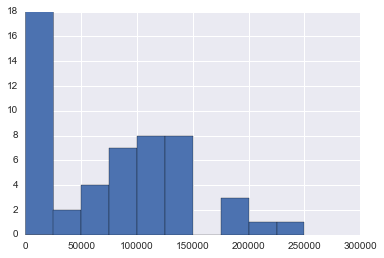

In [35]:
df2.est_sal.hist() 

In [36]:
driver2 = webdriver.PhantomJS(executable_path=path_phantom)

In [80]:
linkedin_url = 'https://www.linkedin.com/jobs/search?keywords=Data+Scientist&locationId=STATES.us.ny&start={}&count=25&trk=jobs_jserp_pagination_next'

In [81]:
driver2.get(linkedin_url.format(0))

https://www.linkedin.com/jobs/search?keywords=Data+Scientist&locationId=STATES.us.ny&start=25&count=25&trk=jobs_jserp_pagination_next

In [82]:
soup2 = BeautifulSoup(driver2.page_source, 'lxml')

In [83]:
print soup2.prettify()

<!DOCTYPE html>
<!--[if lt IE 7]> <html lang="en" class="ie ie6 lte9 lte8 lte7 os-mac"> <![endif]-->
<!--[if IE 7]> <html lang="en" class="ie ie7 lte9 lte8 lte7 os-mac"> <![endif]-->
<!--[if IE 8]> <html lang="en" class="ie ie8 lte9 lte8 os-mac"> <![endif]-->
<!--[if IE 9]> <html lang="en" class="ie ie9 lte9 os-mac"> <![endif]-->
<!--[if gt IE 9]> <html lang="en" class="os-mac"> <![endif]-->
<!--[if !IE]><!-->
<html class="os-mac" lang="en">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <title>
   Data Scientist Jobs in New York | LinkedIn
  </title>
  <meta content="origin" name="referrer"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="af2eb8ea-4900-4c0b-aaa5-7038b35cb63e" name="pageImpressionID"/>
  <meta content="chrome" name="appName"/>
  <meta content="6X0rbKC+fRSAnUlN9SoAAA==" name="treeID"/>
  <meta content="//www.linkedin.com/mob/tracking" name="globalTrackingUrl"/>
  <meta content="chrome" name="globalTrackingAppName"/>
  <meta content="web

In [91]:
for i in soup2.findAll('div', class_='job-details'):
    print i.find('span', class_='job-title-text').text
    print i.find('span', class_='company-name-text').text
    print i.find('span', class_='job-location').text
    print i.find('div', class_='job-description').text
#     print i.prettify()
    print""

Data Scientist
2U
Greater New York City Area
This is a highly quantitative role that requires analytical aptitude, strong programming skills, intellectual curiosity and the ability ... 

Data Scientist
Scholastic
New York, New York
Scholastic is a seeking a highly skilled, creative, and driven Data Scientist to design and build approaches which will help Scholastic ... 

Data Scientist
Wylei
Greater New York City Area
Compensation is benchmarked to market rates and is commensurate with candidate experience level. Professional experience as a data scientist. 

Data Scientist
Smith Hanley Associates
Greater New York City Area
This position exists within the Methodology and Protocols team, a core function in Research Science that is responsible for developing ... 

Data Scientist
National Grid
Brooklyn, New York
The Data Scientist is responsible for working to provide data driven solutions and conclusions from several different sources of ... 

Data Scientist
Komodo Health
Greater New Yor